In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.interpolate import interp1d

%matplotlib inline

beta = .09
r = .02
w = 1
p = 2
beta = 0.95
z_high = 1.5
z_low = .5

Pr_LL = .5
Pr_LH = .5
Pr_HL = .5
Pr_HH = .5
N = 500
maxiter = 1000
xmax = 10


In [2]:
xvals = np.linspace(.01, xmax, N)
yvals_L = np.zeros(N) # start with the zero function
yvals_H = np.zeros(N) # start with the zero function
yvals = np.array([yvals_L,yvals_H]) # value function
asset = np.array([np.zeros(N), np.zeros(N)])
cons = np.array([np.zeros(N), np.zeros(N)])

yvals.shape


(2, 500)

In [3]:
tol = 1E-5
dist = 1 # 1 is just a large value to initialize dist

def u(c):
    return (c**(1-p)-1)/(1-p)
def g(x, a_next, V_L, V_H, z):
   
    if x-a_next>= 0:
        if z == z_low:
            #print(f"output {u(x-a_next) + beta*(Pr_LL*V_L + Pr_LH*V_H)}")
            return u(x-a_next) + beta*(Pr_LL*V_L + Pr_LH*V_H)
        
        if z == z_high:
            return u(x-a_next) + beta*(Pr_HL*V_L + Pr_HH*V_H)
            # return u(x-a_next) + beta*((Pr_HL*V((1+r)*a_next + w*z_low) + Pr_HH*V((1+r)*a_next + w*z_low)))
    else:
        print("ninf")
        return np.NINF # return negative infinity if consumption is negative
def sup(arr): # sup norm (max of absolute value)
    return la.norm(arr, np.inf)



In [4]:
tol = .0000001
dist = 1
counter = 0
while dist > tol and counter < maxiter:

    
    new_yvals = np.copy(yvals)
    #V = np.interp(xvals, xvals, yvals)
    #print(f"yvals {yvals}")
    
    # for each x
    for i in range(1,N): # starting from zero causes issues
    # compute new value function
        # evaluate g() at all values of a_next
        evals_L = np.array([g(xvals[i], xvals[j], yvals[0][j], yvals[1][j], z_low) for j in range(i)])
        evals_H = np.array([g(xvals[i], xvals[j], yvals[0][j], yvals[1][j], z_high) for j in range(i)])   
        new_yvals[:,i] = [max(evals_L), max(evals_H)] # take maximum value of g
        
        # compute new assets/consumption
        asset[:,i] = [xvals[np.argmax(evals_L)], xvals[np.argmax(evals_H)]]
        cons[:,i] = np.array([xvals[i],xvals[i]]) - asset[:,i]
        
    counter +=1
    
    dist = max(sup(new_yvals[0] - yvals[0]), sup(new_yvals[1] - yvals[1]))
    
    yvals = new_yvals
    
    

In [5]:
# get actual evaluable functions
asset_func_low = interp1d(xvals, asset[0])
asset_func_high = interp1d(xvals, asset[1])
def asset_func(x, z):
    if z == z_low:
        return asset_func_low(x)
    if z == z_high:
        return asset_func_high(x)
    
cons_func_low = interp1d(xvals, cons[0])
cons_func_high = interp1d(xvals, cons[1])
def cons_func(x, z):
    if z == z_low:
        return cons_func_low(x)
    if z == z_high:
        return cons_func_high(x)

asset_func_low(5)

array(2.47246493)

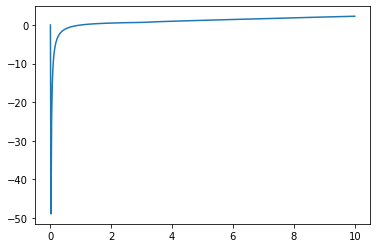

In [6]:
plt.figure(2)
plt.plot(xvals,yvals[1])


In [7]:
# Check that the additional restriction does not bind
bind = False
for i in range(N):
    for j in range(1):
        if (1+r)*asset[j,i] + w*1.5 >= xmax:
            bind = True
if bind == True:
    print("additional restriction DOES bind")
    
if bind == False:
    print("additional restriction does NOT bind")
        



additional restriction does NOT bind


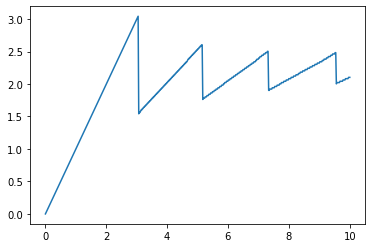

In [8]:
plt.plot(xvals, cons[0]) # plot low consumption function

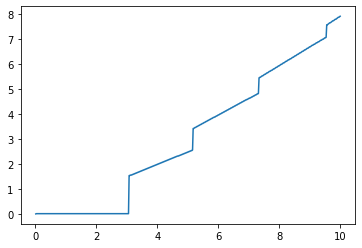

In [9]:
plt.plot(xvals, asset[0]) # plot low asset function

In [10]:
def shock(z, Pr_LL, Pr_LH, Pr_HL, Pr_HH):
    if z == z_low:
        if np.random.rand() < Pr_LL:
            z_next = z_low
        else:
            z_next = z_high
    if z == z_high:
        if np.random.rand() < Pr_HL:
            z_next = z_low
        else:
            z_next = z_high
    return z_next
    

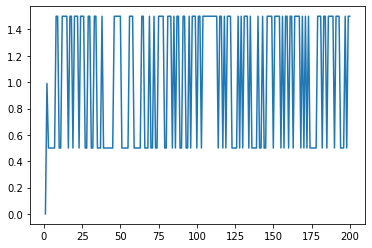

In [14]:
# initialization
asset_path = np.zeros(200); cons_path = np.zeros(200)
shock_path = np.zeros(200); x_path = np.zeros(200); wage_path = np.zeros(200)
# initial conditions
asset_path[0] = 0; x_path[0] = w; shock_path[0] = z_low; wage_path[0] = w 

for i in range(1, 200): # double check for OBOE
    cons_path[i] = cons_func(x_path[i-1], shock_path[i-1])
    asset_path[i] = asset_func(x_path[i-1], shock_path[i-1])
    shock_path[i] = shock(shock_path[i-1], Pr_LL, Pr_LH, Pr_HL, Pr_HH)
    wage_path[i] = w*shock_path[i]
    x_path[i] = (1+r)*asset_path[i] + wage_path[i]

plt.plot(np.linspace(1,200, 200), cons_path) # plot consumption




    

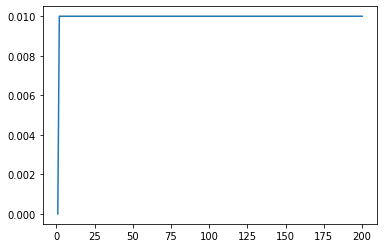

In [15]:
plt.plot(np.linspace(1,200, 200), asset_path) # plot assets